In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [74]:
background = pd.read_csv("anon-data/background.csv")
participated = pd.read_csv("anon-data/participated.txt", names=["id"])
control = pd.read_csv("anon-data/control.txt", names=["id"])
experimental = pd.read_csv("anon-data/experimental.txt", names=["id"])


In [75]:
participated_list = [x[0] for x in participated.values.tolist()]
background = background[background["id"].isin(participated_list)]

In [76]:
control_list = [x[0] for x in control.values.tolist()]
experimental_list = [x[0] for x in experimental.values.tolist()]

In [77]:
background_control = background[background["id"].isin(control_list)].drop('id', axis=1)
background_experimental = background[background["id"].isin(experimental_list)].drop('id', axis=1)

In [78]:
def get_num(elem):
    num_to_eval = None

    if type(elem) == type(1):
        return elem

    if '-' in elem:
        num_to_eval = int(elem.split("-")[0])
    elif "or" in elem:
        num_to_eval = int(elem.split("or")[0].strip())
    else:
        num_to_eval = int(elem)
    return num_to_eval

def sort_lists(x, y, y2):
    has_numbers = any(char.isdigit() for char in x[0])
    if not has_numbers:
        return x, y, y2
    
    copy_x = x.copy()
    new_x = []
    new_y = []
    new_y2 = []

    for i in x:
        aux = 1000
        min_index = 0

        for index, str_val in enumerate(copy_x):
            val = get_num(str_val)
            if val < aux:
                aux = val
                min_index = index
        new_x.append(x[min_index])
        new_y.append(y[min_index])
        new_y2.append(y2[min_index])
        copy_x[min_index] = 1000
        

    return new_x, new_y, new_y2

In [79]:
def process_col(colname):
    control_vals = background_control[colname].unique()
    experimental_vals = background_experimental[colname].unique()

    x = []
    for i in control_vals:
        if i not in x:
            x.append(i)
    for i in experimental_vals:
        if i not in x:
            x.append(i)

    value_count_df_control = background_control[colname].value_counts().reset_index()
    value_count_df_control.columns = ["Answer", "counts"]
    answer_count_control = dict(zip(value_count_df_control["Answer"], value_count_df_control["counts"])) 

    value_count_df_experimental = background_experimental[colname].value_counts().reset_index()
    value_count_df_experimental.columns = ["Answer", "counts"]
    answer_count_experimental = dict(zip(value_count_df_experimental["Answer"], value_count_df_experimental["counts"])) 

    for key in answer_count_control:
        if key not in answer_count_experimental:
            answer_count_experimental[key] = 0

    for key in answer_count_experimental:
        if key not in answer_count_control:
            answer_count_control[key] = 0

    y = []
    y2 = []

    for i in x:
        y.append(answer_count_control[i])
        y2.append(answer_count_experimental[i])

    x, y, y2 = sort_lists(x, y, y2)

    return pd.Series(x), y, y2

In [80]:
def plot_question(question, xlabel, title, filename):
    x, y, y2 = process_col(question)
    x_axis = np.arange(len(x))
    width = 0.4
    plt.bar(x_axis, height=y, width=width, label="Control")
    plt.bar(x_axis + width, height=y2, width=width, label="Experimental")

    plt.xticks(x_axis,x)
    # plt.xticks(rotation=)

    min_y = min(y)
    min_y2 = min(y2)
    min_val = min_y if min_y < min_y2 else min_y2

    max_y = max(y)
    max_y2 = max(y2)
    max_val = max_y if max_y > max_y2 else max_y2

    plt.yticks(range(min_val, max_val + 1))

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Number of participants")
    plt.legend()

    plt.savefig(f"images/{filename}")

    plt.show()

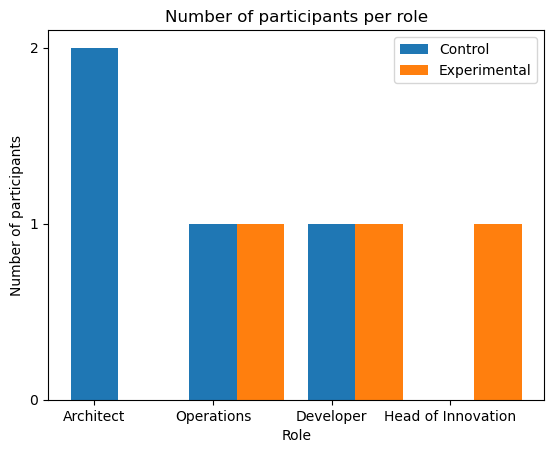

In [81]:
plot_question("What is your current role?", "Role", "Number of participants per role", "participants_role.svg")

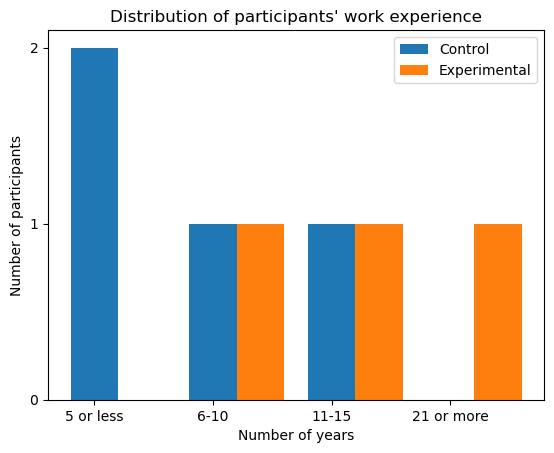

In [82]:
plot_question("Approximately how many years of professional experience do you have in software development and related tasks?", "Number of years", "Distribution of participants' work experience", "general_experience.svg")

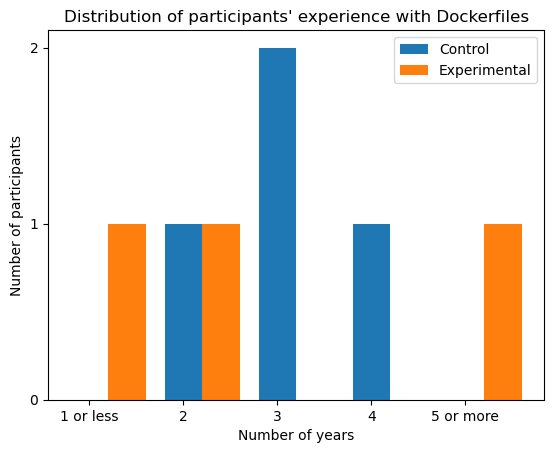

In [83]:
plot_question("Approximately how many years of professional experience do you have developing Dockerfiles?", "Number of years", "Distribution of participants' experience with Dockerfiles", "dockerfile_experience.svg")

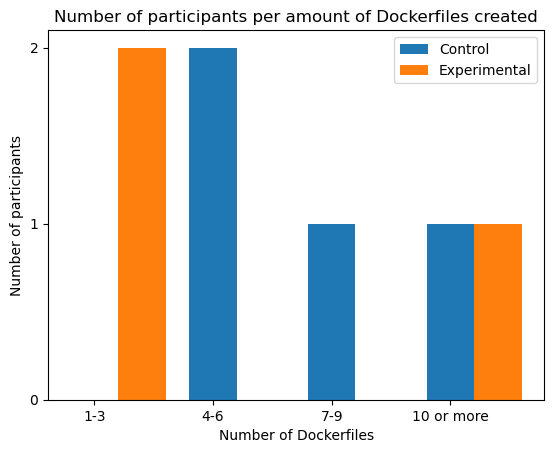

In [84]:
plot_question("Approximately how many Dockerfiles have you written from scratch into a working first version?", "Number of Dockerfiles", "Number of participants per amount of Dockerfiles created", "dockerfile_experience_written.svg")

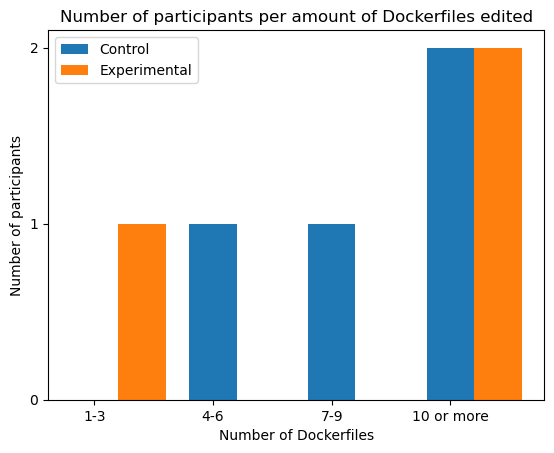

In [85]:
plot_question("Approximately how many Dockerfiles have you edited?", "Number of Dockerfiles", "Number of participants per amount of Dockerfiles edited", "dockerfile_experience_edited.svg")

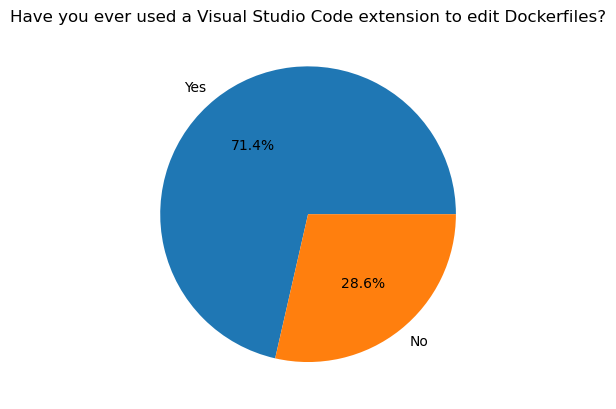

In [86]:
labels = ["Yes", "No"]
yes_count = 0
no_count = 0
used_extension = background["Have you ever used a Visual Studio Code extension to edit Dockerfiles?"]
for i in used_extension:
    if i == "Yes":
        yes_count += 1
    else:
        no_count += 1
sizes = [yes_count/len(used_extension),no_count/len(used_extension)]   
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Have you ever used a Visual Studio Code extension to edit Dockerfiles?")
plt.savefig("images/extension_usage.svg")
plt.show()